# Практическое задание 4 

# Мультиязычный тематический поиск

## курс "Математические методы анализа текстов"


### ФИО: Садиев Абдурахмон Абдужалолович

## Введение

### Постановка задачи:

В этом задании вам предстоит сделать свою небольшую мультиязычную поисковую систему. Проще всего строить мультиязычные системы, имея "параллельные" данные: словари или корпуса параллельных текстов. 

В задании необходимо, имея англо-русскую и агло-испанскую коллекции, обучить модель поиска модель поиска испанских текстов по русским.

Решение этого задания будет основано на тематическом моделировании, а именно подходе аддитивной регуляризации.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [bigartm](http://bigartm.org/)
 - [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
 - [nltk](http://www.nltk.org/)


### Данные

Данные — записи выступлений конференции TED Talks на трёх языках. 

Все данные содержатся в архиве `ted_collection`. В папке содержится три подпапки `/en`, `/ru` и `/es`, каждая из которых соответствует коллекции для отдельного языка. Папка `parallel_info`  содержит информацию о связях документов между коллекциями. Файл `titles_file.json` содержит информацию о заголовках документов английской коллекции.

Ссылка для скачивания данных: [ссылка на гугл диск](https://drive.google.com/file/d/1B3kDfISvWnVpEet_CDa6oLNp028mEak-/view)

#### Импорт важных библиотек

In [1]:
# считывание
import os
import glob
import json

# предобработка
import pymorphy2
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [2]:
# загрузка коллекции
from lab4_utils import load_collection

# загрузка информации о параллельных документах
from lab4_utils import load_parallel_documents_info

# запись vowpal wabit файла специального формата
from lab4_utils import write_vw_lab4

# подсчёт позиции в выдаче переводов текстов
from lab4_utils import get_indexes_of_relevant_documents

## Предобработка данных (3 балла)

Перед тем как начать моделировать, необходимо предобработать данные. 

Заметим, что для английского языка некоторые этапы обработки не оказывают сильного влияния на модель (например, лемматизация). В русском языке одному слову может соответствовать огромное количество различных форм, поэтому без лемматизации невозможно получить модель с хорошим качеством.

#### Предобработка русских текстов


Считываем коллекцию:

In [3]:
RU_DATA_PATH = 'ted_collection/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	10 марта 2011 года я был в Кембридже в MIT Media Lab на встрече с профессорами, студентами и персона...
	Последние 10 лет я провёл, пытаясь понять, как и почему люди объединяются в социальные сети. Социаль...
	Кое-что в физике не давало мне покоя с самого детства. Речь идёт о вопросе, которым учёные задаются ...
	26 января 2013 года боевики «Аль-Каиды» ворвались в древний город Тимбукту на юге Сахары. Они подожг...
	Вам знакомо расхожее мнение, что защита климата – занятие дорогое, иначе проблема была бы давно реше...

Some file names examples: 
	ru_2334
	ru_1783
	ru_2106
	ru_927
	ru_2562


Выведите полностью несколько документов. Подумайте, какую информацию из них можно удалить на этапе предобработки, не ухудшив качество решения задачи.

In [14]:
index_documents = list(ru_collection.keys())
print(ru_collection['ru_2334'])

10 марта 2011 года я был в Кембридже в MIT Media Lab на встрече с профессорами, студентами и персоналом, и мы пытались выяснить, следует ли мне быть следующим руководителем.
Той ночью, в полночь, землетрясение силой 9 баллов ударило по тихоокеанскому побережью Японии. Моя жена и семья были в Японии, и по мере поступления новостей я начал паниковать. Я смотрел новостные ленты и слушал пресс-конференции представителей правительства и компании Tokyo Power о взрыве на ядерном реакторе и облаке радиоактивных осадков, движущемся по направлению к моему дому, всего в 200 километрах от него. По телевизору не говорили ничего, что хотелось бы слышать. Я хотел знать, что происходит с реактором, с радиацией, в опасности ли моя семья.
И я сделал то, что инстинктивно казалось мне правильным, а именно, зашёл в интернет и попытался выяснить, смогу ли я взять дело в свои руки. В интернете я обнаружил множество людей, пытающихся, как и я, выяснить, что происходит, и все вместе мы спонтанно создали группу

In [15]:
ru_collection['ru_666']
re.sub(r'[^a-zA-Z\s]', '', ru_collection['ru_23']).lower().replace('\n', '')

То, что вы делаете прямо сейчас, в этот самый момент, вас убивает. Технология, которой вы пользуетесь каждый день, чаще чем Интернетом, машинами, этим маленьким мобильным устройством, о котором мы не прекращаем говорить, — это вот это, ваш зад. В наше время люди сидят 9,3 часа в день, а это больше, чем мы спим, 7,7 часа. Сидеть на месте настолько привычно, что мы даже не задумываемся, как долго мы это делаем, и оттого что все остальные тоже этим занимаются, нам даже не приходит в голову, что это неправильно. В этом смысле сидение на месте стало курением нашего поколения.
Разумеется, последствия для нашего здоровья ужасны, и дело не только в объёме талии. Такие болезни, как рак груди, рак толстой кишки в 10% случаев непосредственно связаны с недостатком физической активности, сердечные заболевания — в 6% случаев, диабет второго типа, от которого умер мой отец, — в 7% случаев. Любая из этих цифр должна бы убедить нас чаще поднимать свой зад, но если вы хоть чуть похожи на меня, этого не 

Просмотрев несколько документов, я пришел к выводу, что стоит удалить слова такие как: местоимения, междометья, честицы, союзы, предлоги. Поскольку они не несут смысловой нагрузки. Но номально это сделать, как просто удалить слова длины 2. Кстати, поскольку это речи из TEDTalks, то стоить удалить слова: `смех`, `спасибо`,`аплодисменты`.


После обработки нескольких текстов, я прочел их и увидел, что слово `это` не удоляется. Поэтому я решил еще самостоятельно удолять его из текстов 

Помимо удаления специфичной информации, вам необходимо провести для русского языка следующие шаги предобработки :

1. Приведение документов к нижнему регистру.

2. Удаление всех символов кроме букв.
    1. Для некоторых способов выделения коллокаций (см. бонусную часть), может быть полезна информация о знаках препинания. Также она полезна при необходимости строить синтаксический разбор предложения.
    2. Вам может помочь функция sub из библиотеки re.
3. Токенизация документов.
    1. Воспользуйтесь стандартным методом .split, функцией split из библиотеки re или одним из токенайзеров библиотеки nltk.
4. Лемматизация документов.
    1. Воспользуйтесь библиотекой pymorphy2
    2. Шаги 3 и 4 можно выполнить вместе, воспользовавшись библиотекой mytem (или её обёрткой на python pymystem)
5. Удаление стоп-слов
    1. Базовый список стоп слов можно получить из модуля nltk.corpus

После выполнения всех шагов сохраните результат в словарь аналогичный ru_collection (ключи - названия файлов, значения - предобработанный документ в формате str).



In [37]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdurakhmonsadiev/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [87]:
stop_words = stopwords.words("russian")

stop_words_for_russian = stop_words + ['спасибо', 'аплодисменты', 'смех', 'это']

In [88]:
print(stop_words_for_russian)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [79]:
document = re.sub(r'[^а-яА-Я\s]', '', ru_collection['ru_44']).lower().replace('\n', ' ').split()# пункт 1 - 3
document_normal = []
for word in document:
    morph = pymorphy2.MorphAnalyzer()
    p = morph.parse(word)[0]
    word = p.normal_form
    if word not in stop_words and len(word) > 2:
        document_normal.append(word)
document_normal = ' '.join(document_normal)

In [80]:
document_normal

'детство хотеться супергерой хотеть спасти мир сделать весь счастливый знать потребоваться невероятный способность достижение мечта поэтому совершать воображать путешествие поиск межгалактический предмет планета криптон это очень весело приносить результат вырасти осознать научный фантастика хороший источник сверхъестественный способность решить отправиться путешествие настоящий наука отыскать полезный истина начать путешествие калифорния летний панельный исследование университет беркли который изучаться фотография студент старый выпускной альбом производиться оценка успешность благополучие протяжение жизнь измерять улыбка студент исследователь смочь предсказать насколько прочный долгий оказаться брак сколько балл набрать стандартный тест благополучие влияние окружающий друг выпускной альбом наткнуться фотография барри обама впервые увидеть фотография подумать источник невероятный способность невероятный воротник знать дело улыбка озарение иметь место исследовательский проект университ

In [90]:
from tqdm import tqdm

In [91]:
morph = pymorphy2.MorphAnalyzer()
ru_collection_normal = {}
for key, document in tqdm(ru_collection.items()):
    document = re.sub(r'[^а-яА-Я\s]', '', ru_collection[key]).lower().replace('\n', ' ').split()# пункт 1 - 3
    document_normal = []
    for word in document:
        p = morph.parse(word)[0]
        word = p.normal_form
        if word not in stop_words_for_russian and len(word) > 2:
            document_normal.append(word)
            
    document_normal = ' '.join(document_normal)
    ru_collection_normal[key] = document_normal
    


100%|██████████| 2731/2731 [15:23<00:00,  2.96it/s]


Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

In [94]:
ru_collection_normal['ru_888']

'конец год планета около миллиард человек который активно использовать социальный сеть единственный объединять весь умереть хотя мысль мочь несколько нездоровый думать некоторый действительно серьёзный момент который стоить обратить внимание впервые заставить задуматься запись блог который ранее год сделать дерек миллер который журналист область наука технология умереть рак миллер свой семь друг написать запись который опубликовать вскоре сметереть написать начало сказать оно умереть последний запись мыть блог заранее попросить тело полностью сломаться давление рак семья друг опубликовать написать сообщение часть процесс превращение активный вебсайт архив важный журналист архив миллер мочь хороший написать аккуратный проверить иметь значение сегодня весь создавать архив чтоть отличный чеголибо создаваться предыдущий поколение обратить внимание несколько статистика данный момент часы видео загружаться каждый минута миллион сообщение публиковаться каждый день средний пользователь создава

После обработки нескольких текстов, я прочел их и увидел, что слово `это` не удоляется. Поэтому я решил еще самостоятельно удолять его из текстов. См. выше (`stop_words_for_russian`)

#### Предобработка английских текстов

Считываем коллекцию:

In [471]:
EN_DATA_PATH = 'ted_collection/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	Today, I want you to look at children who become suicide bombers through a completely different lens...
	I have a very difficult task. I'm a spectroscopist. I have to talk about astronomy without showing y...
	I really am honored to be here, and as Chris said, it's been over 20 years since I started working i...
	Thirteen years ago, we set ourselves a goal to end poverty. After some success, we've hit a big hurd...
	One thing the world needs, one thing this country desperately needs is a better way of conducting ou...

Some file names examples: 
	en_495
	en_1635
	en_2282
	en_1407
	en_1063


Проведите все этапы предобработки для английского языка (шаг 4 опционален, можно использовать WordNetLemmatizer из nltk):

Поскольку строчка  `TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.` удаляется в русском языке, но не в английском и испанском, то мы ее тоже удалим. Так же нужно удалить аплодисменты и разные вещи в этом духе, они находятся в скобачках.

In [472]:
stop_words = stopwords.words("english")

In [474]:
lemmatizer = nltk.stem.WordNetLemmatizer()
en_collection_normal = {}
for key, document in tqdm(en_collection.items()):
    document = en_collection[key].lower()
    document = re.sub('© ted .*','', document)
    document = re.sub('\(.*?\)', '', document)
    document = re.sub('ted.com .*', '', document)
    document = re.sub(r'[^a-zA-Z\s]', '',document).replace('\n', ' ').split()# пункт 1 - 3
    document = [lemmatizer.lemmatize(word) for word in document] # пункт 4
    document_normal = []
    for word in document:
        if word not in stop_words and len(word) > 2 :
            document_normal.append(word)
            
    document_normal = ' '.join(document_normal)
    en_collection_normal[key] = document_normal




  0%|          | 0/2856 [00:00<?, ?it/s]


  0%|          | 2/2856 [00:00<02:58, 15.98it/s]


  0%|          | 6/2856 [00:00<02:27, 19.34it/s]


  0%|          | 14/2856 [00:00<01:54, 24.83it/s]


  1%|          | 23/2856 [00:00<01:29, 31.59it/s]


  1%|          | 33/2856 [00:00<01:12, 39.11it/s]


  1%|▏         | 40/2856 [00:00<01:02, 44.99it/s]


  2%|▏         | 48/2856 [00:00<00:54, 51.20it/s]


  2%|▏         | 56/2856 [00:00<00:49, 56.58it/s]


  2%|▏         | 64/2856 [00:00<00:45, 60.81it/s]


  3%|▎         | 73/2856 [00:01<00:41, 66.82it/s]


  3%|▎         | 81/2856 [00:01<00:44, 62.88it/s]


  3%|▎         | 88/2856 [00:01<00:43, 63.99it/s]


  3%|▎         | 95/2856 [00:01<00:43, 64.17it/s]


  4%|▎         | 103/2856 [00:01<00:40, 67.79it/s]


  4%|▍         | 112/2856 [00:01<00:37, 73.17it/s]


  4%|▍         | 120/2856 [00:01<00:38, 71.56it/s]


  4%|▍         | 128/2856 [00:01<00:37, 72.12it/s]


  5%|▍         | 136/2856 [00:01<00:37, 71.88it/s]


  5%|▌         

 83%|████████▎ | 2359/2856 [00:29<00:05, 91.14it/s]


 83%|████████▎ | 2369/2856 [00:29<00:05, 91.38it/s]


 83%|████████▎ | 2380/2856 [00:30<00:05, 94.33it/s]


 84%|████████▎ | 2390/2856 [00:30<00:05, 90.73it/s]


 84%|████████▍ | 2400/2856 [00:30<00:05, 89.63it/s]


 84%|████████▍ | 2410/2856 [00:30<00:05, 89.05it/s]


 85%|████████▍ | 2419/2856 [00:30<00:05, 85.27it/s]


 85%|████████▌ | 2428/2856 [00:30<00:05, 83.78it/s]


 85%|████████▌ | 2437/2856 [00:30<00:05, 77.56it/s]


 86%|████████▌ | 2446/2856 [00:30<00:05, 79.98it/s]


 86%|████████▌ | 2455/2856 [00:31<00:04, 80.78it/s]


 86%|████████▋ | 2464/2856 [00:31<00:04, 81.05it/s]


 87%|████████▋ | 2473/2856 [00:31<00:04, 77.58it/s]


 87%|████████▋ | 2481/2856 [00:31<00:04, 75.97it/s]


 87%|████████▋ | 2489/2856 [00:31<00:04, 74.94it/s]


 87%|████████▋ | 2497/2856 [00:31<00:04, 72.50it/s]


 88%|████████▊ | 2505/2856 [00:31<00:05, 69.30it/s]


 88%|████████▊ | 2514/2856 [00:31<00:04, 71.00it/s]


 88%|████████▊ | 2522/2856 [

#### Предобработка испанских текстов 

Считываем коллекцию:

In [220]:
ES_DATA_PATH = 'ted_collection/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)
stop_words = stopwords.words("spanish")

Total number of documents: 2809

Some document examples: 
	Era mi tercer día de trabajo en una empresa emergente en Silicon Valley a principios de 2013. Tenía ...
	Estamos en un momento crítico. Nuestros líderes, algunas de nuestras grandes instituciones nos están...
	Este es el museo de Historia Natural de Rotterdam, donde trabajo como curador. Cuido la colección y ...
	Chris Anderson: Vamos a tener un debate. El debate es sobre la propuesta: "Lo que el mundo necesita ...
	Soy microbióloga oceanográfica en la Universidad de Tennessee, y quiero hablarles sobre algunos micr...

Some file names examples: 
	es_1801
	es_309
	es_907
	es_1459
	es_2826


Проведите все этапы предобработки для испанского языка (шаг 4 опционален, можно использовать SpanishStemmer из nltk). 

**Замечание.** Регулярное выражение \w из библиотеки re позволяет выделять буквы (в том числе буквы испанского алфавита).

In [478]:
stemmer = nltk.stem.SnowballStemmer("spanish", ignore_stopwords=False)
es_collection_normal = {}
for key, document in tqdm(es_collection.items()):
    document = es_collection[key].lower()
    document = re.sub('© ted .*','', document)
    document = re.sub('\(.*?\)', '', document)
    document = re.sub('ted.com .*', '', document)
    document = re.sub(r'[^\w\s]', '', document).lower().replace('\n', ' ')# пункт 1 - 3
    document = re.sub(r'[0-9]', '', document).split()
    document = [stemmer.stem(word) for word in document] # пункт 4
    document_normal = []
    for word in document:
        if word not in stop_words :
            document_normal.append(word)
            
    document_normal = ' '.join(document_normal)
    es_collection_normal[key] = document_normal




  0%|          | 0/2809 [00:00<?, ?it/s]


  0%|          | 2/2809 [00:00<02:49, 16.53it/s]


  0%|          | 4/2809 [00:00<03:05, 15.13it/s]


  0%|          | 6/2809 [00:00<03:18, 14.13it/s]


  0%|          | 8/2809 [00:00<03:04, 15.21it/s]


  0%|          | 10/2809 [00:00<02:59, 15.62it/s]


  0%|          | 13/2809 [00:00<02:37, 17.80it/s]


  1%|          | 15/2809 [00:00<02:37, 17.73it/s]


  1%|          | 17/2809 [00:01<02:33, 18.14it/s]


  1%|          | 19/2809 [00:01<02:55, 15.93it/s]


  1%|          | 21/2809 [00:01<02:49, 16.40it/s]


  1%|          | 23/2809 [00:01<02:45, 16.85it/s]


  1%|          | 25/2809 [00:01<02:54, 15.95it/s]


  1%|          | 27/2809 [00:01<02:49, 16.43it/s]


  1%|          | 29/2809 [00:01<02:53, 16.02it/s]


  1%|          | 33/2809 [00:01<02:38, 17.56it/s]


  1%|          | 35/2809 [00:02<02:54, 15.91it/s]


  1%|▏         | 37/2809 [00:02<03:08, 14.71it/s]


  1%|▏         | 39/2809 [00:02<03:12, 14.35it/s]


  1%|▏         | 42/28

 23%|██▎       | 653/2809 [00:38<01:49, 19.61it/s]


 23%|██▎       | 656/2809 [00:39<01:59, 18.04it/s]


 23%|██▎       | 658/2809 [00:39<02:05, 17.14it/s]


 23%|██▎       | 660/2809 [00:39<02:00, 17.82it/s]


 24%|██▎       | 662/2809 [00:39<02:22, 15.06it/s]


 24%|██▎       | 664/2809 [00:39<02:29, 14.39it/s]


 24%|██▎       | 666/2809 [00:39<02:37, 13.62it/s]


 24%|██▍       | 669/2809 [00:40<02:25, 14.74it/s]


 24%|██▍       | 672/2809 [00:40<02:09, 16.50it/s]


 24%|██▍       | 674/2809 [00:40<02:09, 16.50it/s]


 24%|██▍       | 676/2809 [00:40<02:16, 15.58it/s]


 24%|██▍       | 679/2809 [00:40<01:58, 17.95it/s]


 24%|██▍       | 681/2809 [00:40<02:16, 15.56it/s]


 24%|██▍       | 683/2809 [00:40<02:09, 16.42it/s]


 24%|██▍       | 685/2809 [00:40<02:11, 16.15it/s]


 24%|██▍       | 687/2809 [00:41<02:12, 16.03it/s]


 25%|██▍       | 689/2809 [00:41<02:12, 16.05it/s]


 25%|██▍       | 691/2809 [00:41<02:16, 15.49it/s]


 25%|██▍       | 693/2809 [00:41<02:10, 16.26i

 47%|████▋     | 1326/2809 [01:17<01:36, 15.39it/s]


 47%|████▋     | 1328/2809 [01:17<01:42, 14.44it/s]


 47%|████▋     | 1330/2809 [01:17<01:39, 14.93it/s]


 47%|████▋     | 1332/2809 [01:17<01:35, 15.52it/s]


 47%|████▋     | 1334/2809 [01:17<01:34, 15.55it/s]


 48%|████▊     | 1336/2809 [01:17<01:46, 13.87it/s]


 48%|████▊     | 1338/2809 [01:18<01:37, 15.01it/s]


 48%|████▊     | 1341/2809 [01:18<01:26, 17.05it/s]


 48%|████▊     | 1344/2809 [01:18<01:22, 17.69it/s]


 48%|████▊     | 1346/2809 [01:18<01:23, 17.42it/s]


 48%|████▊     | 1349/2809 [01:18<01:24, 17.18it/s]


 48%|████▊     | 1352/2809 [01:18<01:18, 18.50it/s]


 48%|████▊     | 1355/2809 [01:18<01:10, 20.65it/s]


 48%|████▊     | 1358/2809 [01:18<01:08, 21.15it/s]


 48%|████▊     | 1361/2809 [01:19<01:14, 19.44it/s]


 49%|████▊     | 1364/2809 [01:19<01:07, 21.42it/s]


 49%|████▊     | 1367/2809 [01:19<01:12, 19.99it/s]


 49%|████▉     | 1370/2809 [01:19<01:11, 20.25it/s]


 49%|████▉     | 1373/2809 [

 69%|██████▉   | 1947/2809 [01:54<01:21, 10.64it/s]


 69%|██████▉   | 1949/2809 [01:54<01:17, 11.14it/s]


 69%|██████▉   | 1951/2809 [01:54<01:13, 11.61it/s]


 70%|██████▉   | 1953/2809 [01:55<01:13, 11.63it/s]


 70%|██████▉   | 1955/2809 [01:55<01:15, 11.31it/s]


 70%|██████▉   | 1957/2809 [01:55<01:45,  8.10it/s]


 70%|██████▉   | 1958/2809 [01:55<01:52,  7.55it/s]


 70%|██████▉   | 1960/2809 [01:55<01:39,  8.51it/s]


 70%|██████▉   | 1961/2809 [01:56<01:48,  7.82it/s]


 70%|██████▉   | 1962/2809 [01:56<02:13,  6.35it/s]


 70%|██████▉   | 1964/2809 [01:56<01:59,  7.04it/s]


 70%|██████▉   | 1966/2809 [01:56<01:47,  7.83it/s]


 70%|███████   | 1967/2809 [01:56<01:42,  8.24it/s]


 70%|███████   | 1968/2809 [01:56<01:48,  7.74it/s]


 70%|███████   | 1969/2809 [01:57<02:10,  6.43it/s]


 70%|███████   | 1970/2809 [01:57<02:06,  6.63it/s]


 70%|███████   | 1971/2809 [01:57<02:05,  6.65it/s]


 70%|███████   | 1973/2809 [01:57<01:43,  8.05it/s]


 70%|███████   | 1975/2809 [

 90%|█████████ | 2534/2809 [02:37<00:17, 15.62it/s]


 90%|█████████ | 2536/2809 [02:37<00:17, 15.31it/s]


 90%|█████████ | 2538/2809 [02:37<00:17, 15.54it/s]


 90%|█████████ | 2540/2809 [02:37<00:17, 15.14it/s]


 91%|█████████ | 2543/2809 [02:37<00:15, 16.94it/s]


 91%|█████████ | 2545/2809 [02:37<00:16, 15.71it/s]


 91%|█████████ | 2548/2809 [02:37<00:15, 16.42it/s]


 91%|█████████ | 2550/2809 [02:37<00:15, 16.71it/s]


 91%|█████████ | 2552/2809 [02:38<00:16, 15.87it/s]


 91%|█████████ | 2555/2809 [02:38<00:14, 17.85it/s]


 91%|█████████ | 2557/2809 [02:38<00:13, 18.34it/s]


 91%|█████████ | 2559/2809 [02:38<00:13, 18.27it/s]


 91%|█████████ | 2561/2809 [02:38<00:14, 17.53it/s]


 91%|█████████ | 2563/2809 [02:38<00:14, 17.08it/s]


 91%|█████████▏| 2565/2809 [02:38<00:16, 15.00it/s]


 91%|█████████▏| 2568/2809 [02:39<00:14, 16.52it/s]


 91%|█████████▏| 2570/2809 [02:39<00:14, 16.12it/s]


 92%|█████████▏| 2572/2809 [02:39<00:14, 16.18it/s]


 92%|█████████▏| 2574/2809 [

#### Дополнительная предобработка

Библиотека BigARTM имеет собственный формат документов для обработки, называемый батчами. Самый простой способ создать батчи из коллекции файлов - сконвертировать в батчи vowpal wabbit файл с коллекцией (https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). 

Тематические модели работают с мешком слов, поэтому в vowpal wabbit файле можно не хранить информацию о порядке слов в документе.

Чтобы обучить мультиязычную модель, мы будем использовать апарат модальностей тематической модели. Каждому языку будет соответствовать своя модальность (`@english`, `@russian` и `@spanish` в vowpal wabbit файле). 

Для экспериментов нам понадобится два файла. Один будет содержать информацию о параллельных документов, а другой нет. В втором файле каждая строчка соответствует конкретному документу. В первом файле, если у документа есть параллельный, он будет располагаться на этой же строчке в рамках другой модальности.

Весь код для сохранения файла в vowpal wabbit формате уже написан, вам только необходимо правильно воспользоваться функцией. В частности, проследите, чтобы в ваших документах не содержалось символов ':', '|' и '@'.

В файлах en_ru_match.txt и en_es_match.txt содержится информация о том, какие документы являются параллельными. 

In [479]:
en_ru_parallel_docs = load_parallel_documents_info('ted_collection/parallel_info/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info('ted_collection/parallel_info/en_es_match.txt')

Total number of pairs: 1000
Total number of pairs: 1000


Воспользуйтесь функцией write_vw_lab4, чтобы сохранить данные в нужном формате:

In [480]:
# vowpal wabbit файлы с коллекцией
DATA_PATH_PARALLEL = 'ted_collection/collection_parallel.vw'
DATA_PATH_MONO = 'ted_collection/collection_mono.vw'

write_vw_lab4(
    DATA_PATH_PARALLEL,
    en_collection_normal,
    ru_collection_normal,
    es_collection_normal,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    en_collection_normal,
    ru_collection_normal,
    es_collection_normal,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

## Базовая моноязычная тематическая модель (2 балла)

Теорию тематического моделирования можно узнать из лекций [9](http://www.machinelearning.ru/wiki/images/7/79/Mmta2018-artm-1.pdf) и [10](http://www.machinelearning.ru/wiki/images/a/ab/Mmta2018-artm-2.pdf).

Научиться пользоваться bigartm легче всего по гайду из документации [ссылка](http://docs.bigartm.org/en/stable/tutorials/python_userguide/index.html).

#### Подготовка к моделированию

Чтобы преобразовать полученный vowpal wabbit файл в батчи, можно воспользоваться стандартным классом BatchVectorizer. Объект этого класса принимает на вход адрес папки с батчами или файл vowpal wabbit, а затем подаётся на вход для обучения методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

В этой части экспериментов, вам предлагается построить моноязычную тематическую модель только для английского языка, поэтому для обучения используйте файл DATA_PATH_MONO.

In [481]:
# папка с батчами
BATCHES_PATH_MONO = 'ted_collection/batches'

In [482]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

Словарь – это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [483]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

Словарь в том числе отвечает за то, на какие токены будет настраиваться модель. Редкие слова не оказывают влияние на модель, поэтому их можно удалить используя метод .filter.

In [484]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=8e454bb7-9a48-4a53-82a2-862c351b5532, num_entries=51433)

In [485]:
dictionary

artm.Dictionary(name=8e454bb7-9a48-4a53-82a2-862c351b5532, num_entries=51433)

#### Обучение модели

Пришло время приступить к моделированию! Начнём с простой одноязычной модели PLSA. Будем учитывать только модальность @english в документах коллекции. Так как коллекция небольшая, используйте небольшое число тем 30-50.

Параметр theta_columns_naming='title' отвечает за именование документов лейблами из vowpal wabbit формата при получении матрицы $\Theta$ (иначе они будут нумероваться в порядке появления в коллекции).

In [492]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1})

model.initialize(dictionary)

Класс artm.ARTM поддерживает различные встроенные метрики качества. Добавьте метрики измерения перплексии, разреженности $\Phi$, разреженности $\Theta$ и счётчик топ слов. Не забудьте, что метрики должны соответствовать только модальности @english!

In [493]:
model.scores.add(artm.PerplexityScore(name='perplexity_score'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='@english'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@english', num_tokens = 20 ))

Проведите обучение модели с помощью метода fit_offline. Подберите необходимое число операций для сходимости в зависимости от значения перплексии:

In [494]:
model.fit_offline(batch_vectorizer = batch_vectorizer_mono, num_collection_passes=10)

Выведите график изменения перплексии в зависимости от итерации алгоритма, чтобы мы знали, что ваш алгоритм точно сошёлся :)

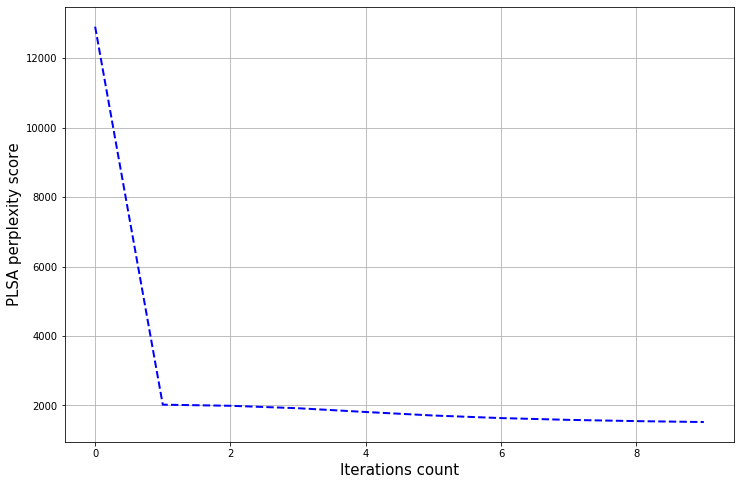

In [495]:
plt.figure(figsize = (12, 8))
plt.plot(range(model.num_phi_updates),
         model.score_tracker['perplexity_score'].value, 'b--', linewidth=2)

plt.xlabel('Iterations count', fontsize = 15)
plt.ylabel('PLSA perplexity score', fontsize = 15)
plt.grid(True)
plt.show()

#### Интерпретация результатов

Основная особенность тематических моделей — интерпретируемость получаемых матриц $\Phi$ и $\Theta$. С помощью $\Phi$ для каждой темы можно узнать топ-слова, а с помощью $\Theta$ для каждой темы можно узнать топ-документы. 
Для того, чтобы получить матрицу $\Theta$, используйте метод .transform.

Для каждой темы выведите топ её слов ($\geq 20$) и топ заголовкой её документов ($\geq 5$). Попробуйте интерпертировать полученные темы, действительно ли темы получаются осмысленными?

In [496]:
file_name_to_title = {}
with open('ted_collection/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [497]:
Theta = model.transform(batch_vectorizer=batch_vectorizer_mono)


In [498]:
for topic in Theta.index.values:
    print(topic + ' : ' + (Theta.loc[topic].nlargest(n = 6).index.values + ' , ').sum() + '\n')

topic_0 : en_1774 , en_1342 , en_988 , en_899 , en_551 , en_880 , 

topic_1 : en_486 , en_2760 , en_100 , en_649 , en_860 , en_746 , 

topic_2 : en_545 , en_378 , en_2032 , en_1125 , en_1937 , en_506 , 

topic_3 : en_1539 , en_2256 , en_1239 , en_1278 , en_692 , en_1341 , 

topic_4 : en_1630 , en_2625 , en_415 , en_2865 , en_2251 , en_2683 , 

topic_5 : en_2838 , en_114 , en_2130 , en_999 , en_1926 , en_1672 , 

topic_6 : en_1313 , en_810 , en_1627 , en_1188 , en_561 , en_1071 , 

topic_7 : en_187 , en_2488 , en_1942 , en_194 , en_2158 , en_1199 , 

topic_8 : en_2572 , en_2778 , en_1951 , en_2208 , en_557 , en_360 , 

topic_9 : en_1023 , en_1110 , en_192 , en_438 , en_393 , en_380 , 

topic_10 : en_1624 , en_2455 , en_2632 , en_2276 , en_1722 , en_1755 , 

topic_11 : en_885 , en_1025 , en_1294 , en_1877 , en_1776 , en_916 , 

topic_12 : en_1868 , en_934 , en_444 , en_2332 , en_2762 , en_1446 , 

topic_13 : en_1269 , en_1174 , en_1751 , en_758 , en_2278 , en_596 , 

topic_14 : en_1921 ,

In [499]:
topic_names_en = list(filter(lambda x: 'en' in x, list(Theta.columns)))

In [502]:
for topic_name in model.topic_names:
    print(topic_name + ': ',model.score_tracker['top_tokens_score'].last_tokens[topic_name], '\n')

topic_0:  ['country', 'world', 'year', 'people', 'africa', 'global', 'china', 'need', 'million', 'also', 'government', 'change', 'area', 'like', 'forest', 'climate', 'percent', 'one', 'much', 'billion'] 

topic_1:  ['cancer', 'patient', 'health', 'care', 'doctor', 'medical', 'disease', 'one', 'like', 'know', 'need', 'hospital', 'treatment', 'many', 'life', 'time', 'way', 'medicine', 'heart', 'woman'] 

topic_2:  ['company', 'money', 'business', 'one', 'work', 'dollar', 'make', 'people', 'market', 'right', 'need', 'get', 'way', 'would', 'well', 'take', 'pay', 'let', 'actually', 'see'] 

topic_3:  ['data', 'technology', 'people', 'thing', 'information', 'really', 'actually', 'time', 'think', 'problem', 'new', 'like', 'work', 'want', 'going', 'need', 'take', 'lot', 'idea', 'could'] 

topic_4:  ['woman', 'men', 'black', 'like', 'year', 'see', 'going', 'gender', 'well', 'applause', 'way', 'man', 'time', 'get', 'girl', 'world', 'mean', 'much', 'one', 'white'] 

topic_5:  ['people', 'world', 

Как мы видим, вывод топ слов через матрицу $\Phi$ и через `Top_Tokens_Score` идентичен. 

Как мы видем модель обучилась примерно так как мы хотели, стоит отметить, что по топ словам можно легко сказать, про что текст. Мы применили не большое число итераций и все достаточно приемлимо. Однако, как мы видим предобработка не убрала такие вещи, как `didn't` или `you're`. Но это уже ошибки предобработки $\smile$

## Мультиязычная тематическая модель (5 баллов)

В этом пункте задания вам будет необходимо обучить мультиязычную тематическую модель.

В данном пункте вы будете реализовывать модель ML-TD (MultiLingual Parallel).

* каждый язык — отдельная модальность
* $\theta_{td}$ — общая для всех параллельных документов

Таким образом на обучении все параллельные документы записываются в одну строку в vowpal wabbit файле.

Оценивать качество модели мы будем на задаче поиска перевода текста. Вам будет необходимо оценить качество трёх переводов: с русского на английский, с испанского на английский и с русского на испанский.

Поиск документов будет устроен следующим образом. Будем для документа d на языке A считать близости со всеми документами на языке B и ранжировать документы языка B по этой близости. Для каждого документа посчитаем позицию истинного перевода документа в выдаче. Итоговая метрика — медиана или среднее таких позиций по всем документам.

Выделим множества документов, для которых не было известно информации об их переводе:

In [504]:
ru_es_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info('ted_collection/parallel_info/es_en_match_test.txt', verbose=False)

Проведите подготовительный этап (создание батчей и словарей) для мультиязычной коллекции DATA_PATH_PARALLEL.

In [505]:
BATCHES_PATH_PARALLEL = 'ted_collection/batches_parallel'

In [506]:
if len(glob.glob(os.path.join(BATCHES_PATH_PARALLEL + '/*.batch'))) < 1:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=DATA_PATH_PARALLEL, 
                                                     data_format='vowpal_wabbit',
                                                     target_folder=BATCHES_PATH_PARALLEL)
else:
    batch_vectorizer_parallel = artm.BatchVectorizer(data_path=BATCHES_PATH_PARALLEL,
                                                     data_format='batches')

In [507]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_PARALLEL)

In [508]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=9e6172be-1217-469a-8fc2-2cece83d09f0, num_entries=51433)

Обучите мультиязычную модель и проинтерпертируйте полученные темы. Если вы всё сделали правильно, то топ-слова различных языков для одной темы должны получиться достаточно похожими.

In [510]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':2, '@russian': 1, '@spanish': 1})

model.initialize(dictionary)

In [511]:
model.scores.add(artm.PerplexityScore(name='perplexity_score'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens = 20 ))

In [513]:
model.fit_offline(batch_vectorizer = batch_vectorizer_parallel, num_collection_passes=200)

Протестируйте качество на трёх задачах перевода. Добейтесь хорошего качества (медиана позиции в выдаче ~ 0, среднее ~ 10). Получить положение в выдаче переводов текстов вам поможет функция get_indexes_of_relevant_documents из модуля lab4_utils. Для того, чтобы всё работало корректно (на тесте не должна быть известна информация о параллельности документов), подавайте в качестве theta результат model.transform(batch_vectorizer_mono).

Возможные способы улучшения:
* изменять количество тем, количество итераций обучения
* изменять веса модальностей
* добавлять регуляризаторы (см. бонусную часть)
* изменять метрику для поиска ближайших документов
* добавлять шаги в предобработку (выделение колокаций)

За нетривиальные подходы могут быть начислены дополнительные бонусные баллы!

In [515]:
Theta = model.transform(batch_vectorizer_parallel)

In [516]:
index_ru_es = get_indexes_of_relevant_documents(Theta, ru_es_parallel_docs_test, metric='cosine')

In [517]:
np.array(index_ru_es[0]).mean(), np.median(np.array(index_ru_es[0]))

(45.96625, 2.0)

In [518]:
index_ru_en = get_indexes_of_relevant_documents(Theta, ru_en_parallel_docs_test, metric='cosine')

In [519]:
np.array(index_ru_en[0]).mean(), np.median(np.array(index_ru_en[0]))

(22.3175, 0.0)

In [520]:
index_es_en = get_indexes_of_relevant_documents(Theta, es_en_parallel_docs_test, metric='cosine')

In [521]:
np.array(index_es_en[0]).mean(), np.median(np.array(index_es_en[0]))

(19.07, 0.0)

Попробуем подкрутить модальности, чтобы лучше заработало))

In [524]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':200, '@russian': 1, '@spanish': 1})

model.initialize(dictionary)

In [525]:
model.scores.add(artm.PerplexityScore(name='perplexity_score'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens = 20 ))

In [526]:
model.fit_offline(batch_vectorizer = batch_vectorizer_parallel, num_collection_passes=200)

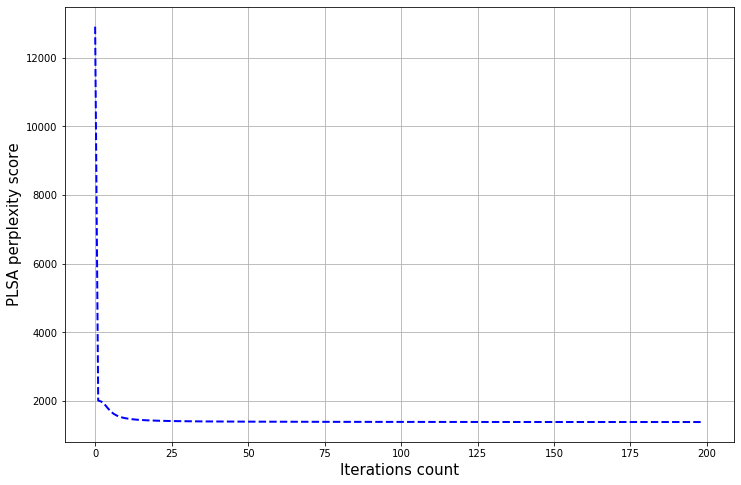

In [527]:
plt.figure(figsize = (12, 8))
plt.plot(range(model.num_phi_updates),
         model.score_tracker['perplexity_score'].value, 'b--', linewidth=2)

plt.xlabel('Iterations count', fontsize = 15)
plt.ylabel('PLSA perplexity score', fontsize = 15)
plt.grid(True)
plt.show()

In [528]:
Theta = model.transform(batch_vectorizer_parallel)

In [532]:
index_ru_es= get_indexes_of_relevant_documents(Theta, ru_es_parallel_docs_test, metric='cosine')
print('ru_es: mean = {0}, median = {1} '.format(np.array(index_ru_es[0]).mean(), np.median(np.array(index_ru_es[0]))))

ru_es: mean = 6.4775, median = 0.0 


In [533]:
index_ru_en = get_indexes_of_relevant_documents(Theta, ru_en_parallel_docs_test, metric='cosine')
print('ru_en: mean = {0}, median = {1} '.format(np.array(index_ru_en[0]).mean(), np.median(np.array(index_ru_en[0]))))

ru_en: mean = 11.8575, median = 0.0 


In [535]:
index_es_en = get_indexes_of_relevant_documents(Theta, es_en_parallel_docs_test, metric='cosine')
print('es_en: mean = {0}, median = {1} '.format(np.array(index_es_en[0]).mean(), np.median(np.array(index_es_en[0]))))

es_en: mean = 4.87375, median = 0.0 


In [565]:
for topic_name in model.topic_names:
    
    en_top_words = list(filter(lambda x: x[0] == '@english', list(phi[topic_name].nlargest(n = 90).index)))[:20]
    top_tokens = [element[1] for element in en_top_words]
    top_tokens = ', '.join(top_tokens)
    print(topic_name + ': ' + top_tokens + ' \n')
    
    ru_top_words = list(filter(lambda x: x[0] == '@russian', list(phi[topic_name].nlargest(n = 90).index)))[:20]
    top_tokens = [element[1] for element in ru_top_words]
    top_tokens = ', '.join(top_tokens)
    print(topic_name + ': ' + top_tokens + ' \n')
    
    es_top_words = list(filter(lambda x: x[0] == '@spanish', list(phi[topic_name].nlargest(n = 90).index)))[:20]
    top_tokens = [element[1] for element in es_top_words]
    top_tokens = ', '.join(top_tokens)
    print(topic_name + ': ' + top_tokens + ' \n')
    
    print(100*'#'+' \n')

topic_0: change, world, year, global, climate, china, need, chinese, future, one, system, percent, carbon, country, time, planet, much, growth, economy, going 

topic_0: год, изменение, наш, весь, который, мочь, климат, китай, мир, проблема, большой, глобальный, страна, будущее, мировой, самый, человек, система, должный, ядерный 

topic_0: mas, cambi, par, chin, nuestr, años, per, mund, com, ten, tod, climat, global, pod, millon, si, econom, hac, futur, sistem 

#################################################################################################### 

topic_1: patient, health, disease, cancer, drug, doctor, care, medical, hospital, treatment, one, people, year, medicine, need, heart, could, percent, blood, many 

topic_1: пациент, который, болезнь, рак, лечение, мочь, человек, врач, исследование, заболевание, медицинский, лекарство, год, здоровье, весь, здравоохранение, проблема, больница, случай, дать 

topic_1: par, medic, pacient, salud, mas, com, canc, per, enfermed, to

topic_20: universe, one, see, star, like, science, would, space, planet, light, theory, time, well, galaxy, year, particle, thats, look, physic, earth 

topic_20: который, мочь, вселенная, наш, весь, год, большой, теория, наука, свет, галактика, самый, планета, частица, очень, видеть, звезда, земля, увидеть, физика 

topic_20: mas, univers, per, com, sol, par, si, tod, nuestr, cienci, fisic, pued, estrell, luz, particul, pod, espaci, teor, planet, ser 

#################################################################################################### 

topic_21: city, people, community, place, new, car, street, building, like, one, neighborhood, home, space, live, public, urban, build, york, way, also 

topic_21: город, человек, место, который, дом, весь, наш, улица, мочь, район, центр, год, дорога, построить, жить, городской, здание, местный, автомобиль, машина 

topic_21: ciud, par, ciudad, com, comun, mas, gent, tod, constru, nuev, viv, dond, person, nuestr, call, per, cas, pued, 

Проведите анализ ошибок. На каких документах модель отработала лучше всего, на каких хуже всего? Как вы думаете почему?

Документы с большой вероятностью

In [581]:
for topic in Theta.index.values:
    
    en_top_topics = list(filter(lambda x: 'en' in x, Theta.loc[topic].nlargest(n = 50).index.values))[:5]
    top_topics = ', '.join(en_top_topics)
    print(topic + ': ' + top_topics + ' \n')
    
    ru_top_topics = list(filter(lambda x: 'ru' in x, Theta.loc[topic].nlargest(n = 50).index.values))[:5]
    top_topics = ', '.join(ru_top_topics)
    print(topic + ': ' +top_topics + ' \n')
    
    es_top_topics = list(filter(lambda x: 'es' in x,  Theta.loc[topic].nlargest(n = 50).index.values))[:5]
    top_topics = ', '.join(es_top_topics)
    print(topic + ': ' + top_topics + ' \n')
    
    print(100*'#'+' \n')

topic_0: en_504, en_2462, en_1664, en_2681, en_2 

topic_0: ru_2681, ru_504, ru_1664, ru_899, ru_676 

topic_0: es_2681, es_1664, es_899, es_777, es_380 

#################################################################################################### 

topic_1: en_486, en_100, en_1869, en_276, en_1674 

topic_1: ru_1788, ru_860, ru_1869, ru_2644, ru_306 

topic_1: es_276, es_100, es_486, es_323, es_1869 

#################################################################################################### 

topic_2: en_2032, en_174, en_956, en_2062, en_1125 

topic_2: ru_956, ru_2062, ru_1109, ru_949, ru_1207 

topic_2: es_2062, es_174, es_829, es_1481, es_274 

#################################################################################################### 

topic_3: en_738, en_1987, en_2603, en_806, en_1341 

topic_3: ru_1341, ru_624, ru_2214, ru_1538, ru_1987 

topic_3: es_738, es_1673, es_1987, es_279, es_1904 

##############################################################

Выведем документы с малыми значениями вероятностей.

In [583]:
for topic in Theta.index.values:
    
    en_top_topics = list(filter(lambda x: 'en' in x, Theta.loc[topic].nsmallest(n = 50).index.values))[:5]
    top_topics = ', '.join(en_top_topics)
    print(topic + ': ' + top_topics + ' \n')
    
    ru_top_topics = list(filter(lambda x: 'ru' in x, Theta.loc[topic].nsmallest(n = 50).index.values))[:5]
    top_topics = ', '.join(ru_top_topics)
    print(topic + ': ' +top_topics + ' \n')
    
    es_top_topics = list(filter(lambda x: 'es' in x,  Theta.loc[topic].nsmallest(n = 50).index.values))[:5]
    top_topics = ', '.join(es_top_topics)
    print(topic + ': ' + top_topics + ' \n')
    
    print(100*'#'+' \n')

topic_0: en_376, en_2488, en_1208, en_1942, en_2059 

topic_0: ru_2488, ru_376, ru_2085, ru_166, ru_1199 

topic_0: es_2488, es_1208, es_1947 

#################################################################################################### 

topic_1: en_2488, en_2059, en_802, en_2150, en_166 

topic_1: ru_2488, ru_1420, ru_648, ru_1942, ru_2085 

topic_1: es_2488, es_1208, es_166, es_802 

#################################################################################################### 

topic_2: en_2488, en_376, en_1208, en_2150, en_2059 

topic_2: ru_2488, ru_1420, ru_187, ru_1199, ru_376 

topic_2: es_2488, es_1208, es_166, es_802, es_2231 

#################################################################################################### 

topic_3: en_2059, en_2085, en_1199, en_795, en_2049 

topic_3: ru_2488, ru_802, ru_187, ru_600, ru_376 

topic_3: es_2488, es_2049, es_816, es_110 

#######################################################################################

In [585]:
print(en_collection['en_2488'])

(Music)
(Applause)
(Music)
(Music) (Applause)
(Music) (Applause) (Applause)
Herbie Hancock: Thank you. Marcus Miller. (Applause) Harvey Mason. (Applause)
Thank you. Thank you very much. (Applause)
TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


In [586]:
print(ru_collection['ru_187'])

(Начало гитарной музыки)
(Конец музыки)
(Аплодисменты)
(Начало гитарной музыки с эффектами искажения)
(Конец музыки)
(Аплодисменты)
(Начало гитарной музыки в стиле эмбиент)
(Конец музыки)
(Аплодисменты)
TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


In [587]:
print(en_collection['en_376'])

Thomas Dolby: For pure pleasure please welcome the lovely, the delectable, and the bilingual Rachelle Garniez.
(Applause)
(Bells)
(Trumpet)
Rachelle Garniez: ♫ Quand il me prend dans ses bras ♫
♫ Il me parle tout bas, ♫
♫ Je vois la vie en rose. ♫
♫ Il me dit des mots d'amour, ♫
♫ Des mots de tous les jours, ♫
♫ Et ca me fait quelque chose. ♫
♫ Il est entre dans mon coeur ♫
♫ Une part de bonheur ♫
♫ Dont je connais la cause. ♫
♫ C'est lui pour moi. Moi pour lui ♫
♫ Dans la vie, ♫
♫ Il me l'a dit, l'a jure [pour] la vie. ♫
♫ Et des que je l'apercois ♫
♫ Alors je sens en moi ♫
♫ Mon coeur qui bat ♫
(Applause)
TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


Как мы наблюдаем, песни и какие-то странные документы, где написано только, что играет музыка, плохо переводятся, поскольку песни имеют  большое количество слов, употребоенных в переносном значении. А документ, где написано, что играет музыка, не содержит большого смысла

Мы получили, то что от нас требовалось в плане функци `get_indexes_of_relevant_documents`. Но как мы видим, есть проблемы со среднем в ru_en. Я думаю, это связано с тем, что предобработка русского языка отличается от предобработки других. Также среди топ слов есть пересечение, что очень радует.

## Бонусная часть

#### Добавление фоновых тем (до 1 балла)

Основной инструмент улучшения качества тематической модели — регуляризация. Выделите часть тем модели как фоновые. Сглаживайте $\Theta$ для фоновых тем, разреживайте для предметных.

Проинтерпретируйте результаты. Фоновые темы должны иметь в качество топ-слов слова фоновой лексики! Удалось ли с помощью введения фоновых тем повысить качество модели?

#### Модальность n-грамм (до 2 баллов)

Для каждого языка добавьте дополнительную модальность n-грамм. n-граммы можно выделить, например, с помощью пакета Phrases из модуля Gensim. Как отразилось добавление новой модальности на интерпретируемости модели? Удалось ли с помощью введения n-грамм повысить качество модели?